In [46]:
import sys
import argparse
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import os

from keras.preprocessing import image
from keras.models import load_model
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D
#from keras.applications.inception_v3 import preprocess_input
from inception_v4 import InceptionV4, preprocess_input

In [2]:
target_size = (299, 299) #fixed size for InceptionV3 architecture


def predict(model, img, target_size):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
        target_size: (w,h) tuple
    Returns:
        list of predicted labels and their probabilities
    """
    if img.size != target_size:
        img = img.resize(target_size)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(image, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        image: PIL image
        preds: list of predicted labels and their probabilities
    """
    plt.imshow(image)
    plt.axis('off')

    plt.figure()
    labels = ['Airport', 'BareLand', 'BaseballField', 'Beach', 'Bridge', 'Center', 'Church', 'Commercial', 'DenseResidential', 'Desert', 'Farmland', 'Forest', 'Industrial', 'Meadow', 'MediumResidential', 'Mountain', 'Park', 'Parking', 'Playground', 'Pond', 'Port', 'RailwayStation', 'Resort', 'River', 'School', 'SparseResidential', 'Square', 'Stadium', 'StorageTanks', 'Viaduct']
    plt.barh(np.arange(len(labels)), preds, alpha=0.5)
    plt.yticks(np.arange(len(labels)), labels)
    plt.xlabel('Probability')
    plt.xlim(0,1.01)
    plt.tight_layout()
    plt.show()

In [3]:
def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet

    Args:
        base_model: keras model excluding top
        nb_classes: # of classes

    Returns:
        new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(FC_SIZE, activation = 'relu')(x) # new FC layer, random init
    predictions = Dense(nb_classes, activation = 'softmax')(x) # new softmax layer
    model = Model(inputs = base_model.input, outputs = predictions)
    return model

In [12]:
FC_SIZE = 1024
base_model = InceptionV4(include_top = False)
model = add_new_last_layer(base_model, 30)
model.load_weights('inception_v4_best_weights.h5')

In [43]:
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    "C:\\AID\\AID-split\\test",
    target_size = (299, 299),
    batch_size = 16,
    class_mode = None,  # only data, no labels
    shuffle = False # keep data in same order as labels
)
probabilities = model.predict_generator(test_generator, verbose=1)
y_pred = np.argmax(probabilities, axis = 1)
y_true = test_generator.classes
cm_array = confusion_matrix(y_true, y_pred)



Found 2000 images belonging to 30 classes.
125/125 [==============================] - 33s 262ms/step


Accuracy: 94.7%


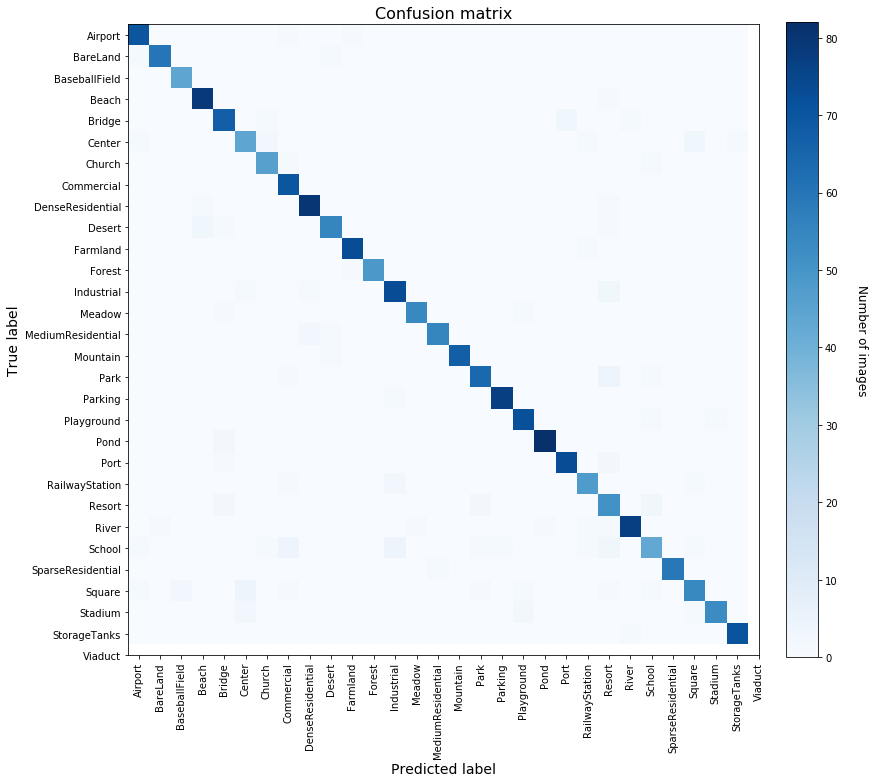

In [51]:
print("Accuracy: {0:0.1f}%".format(accuracy_score(y_true,y_pred)*100))

true_labels = np.unique(y_true)
pred_labels = np.unique(y_pred)
plt.imshow(cm_array[:-1,:-1], interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix", fontsize=16)
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Number of images', rotation=270, labelpad=30, fontsize=12)
xtick_marks = np.arange(len(true_labels))
ytick_marks = np.arange(len(pred_labels))
plt.xticks(xtick_marks, test_generator.class_indices, rotation=90)
plt.yticks(ytick_marks, test_generator.class_indices)
plt.tight_layout()
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

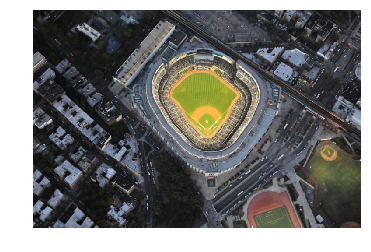

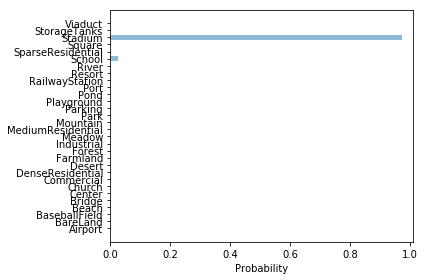

In [13]:
img = Image.open("C:\\Users\\Pedro\\Desktop\\test_image.jpg")
preds = predict(model, img, target_size)
plot_preds(img, preds)

In [15]:
deep_list = [list(map(lambda file: os.path.join(x[0], file), x[2])) for x in os.walk("C:\\AID\\AID-split\\test") if x[1] == []]
test_images = [item for sublist in deep_list for item in sublist]

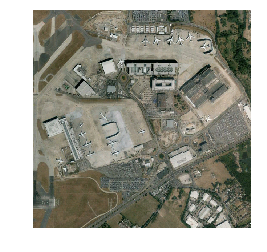

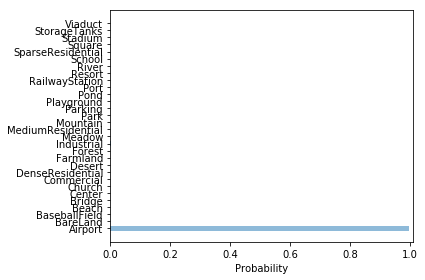

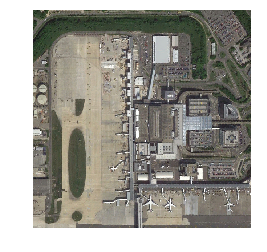

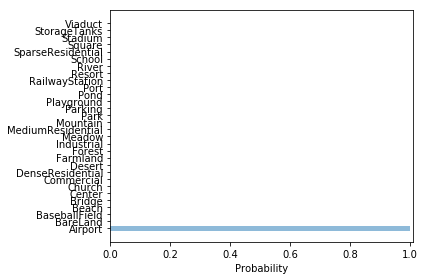

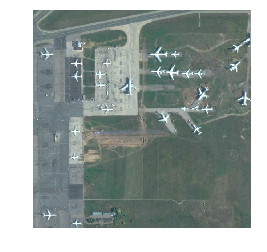

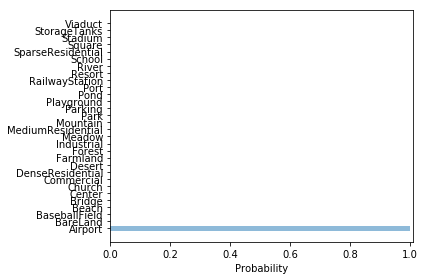

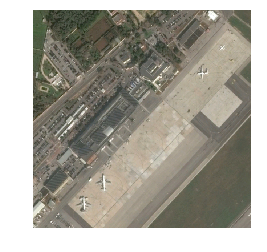

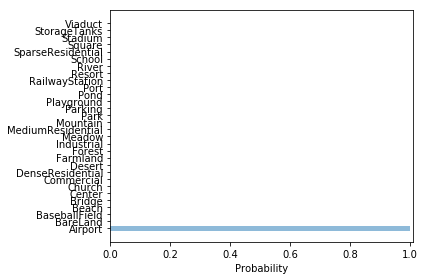

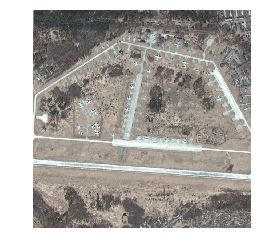

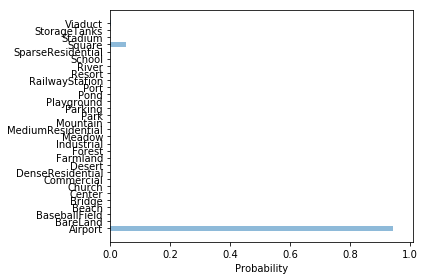

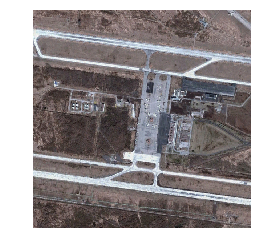

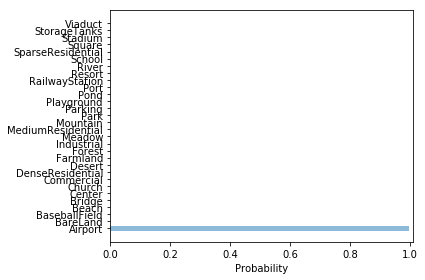

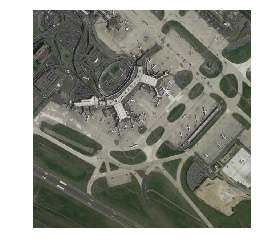

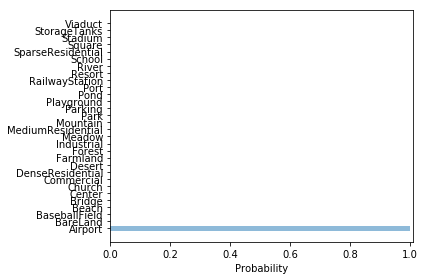

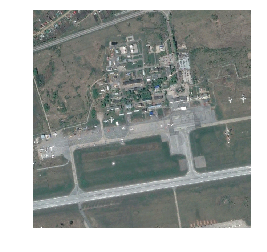

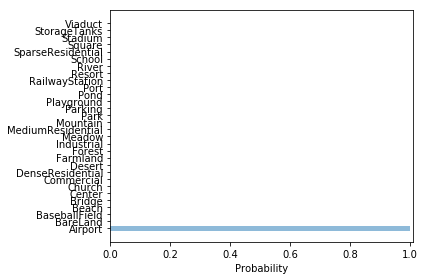

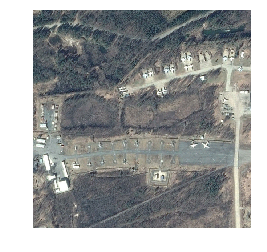

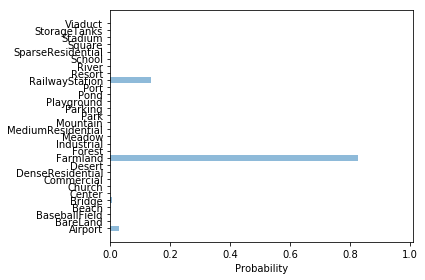

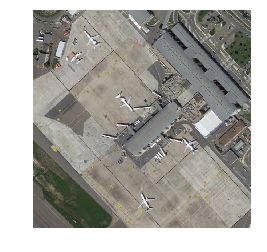

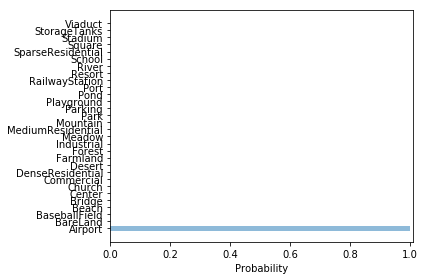

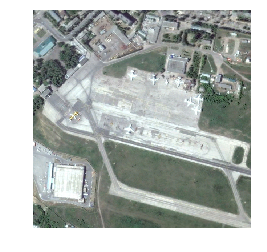

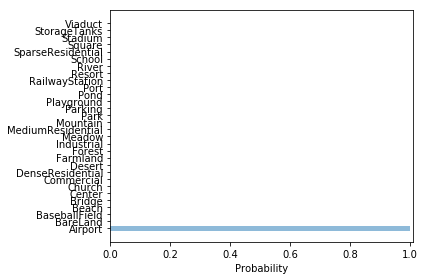

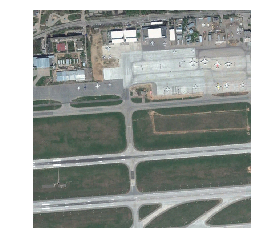

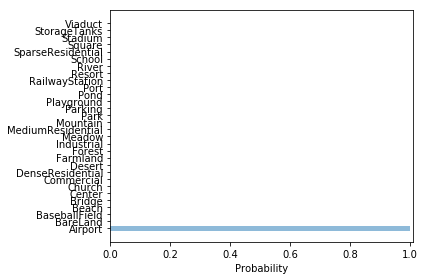

In [16]:
for i, img in enumerate(test_images):
    img = Image.open(img)
    preds = predict(model, img, target_size)
    plot_preds(img, preds)
    if (i > 10):
        break

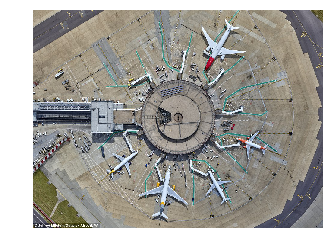

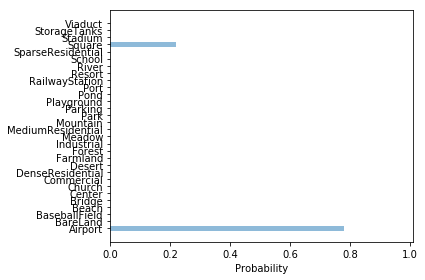

In [18]:
img = Image.open("C:\\Users\\Pedro\\Desktop\\airport_test2.jpg")
preds = predict(model, img, target_size)
plot_preds(img, preds)